<a href="https://colab.research.google.com/github/mithril-security/blindai/blob/jupyter-0.5.0/examples/covidnet/BlindAI-COVID-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this example

This example shows how you can deploy COVID-Net model to analyze X-Ray scans of chest X-rays to detect COVID. 

By using BlindAI, people can send data for the AI to analyze their medical images without having to fear privacy leaks.

COVID-Net is a deep CNN to detect COVID from chest X-rays. You can learn more about it on the [COVID-Net repository](https://github.com/lindawangg/COVID-Net).

More information on this use case can be found on our blog post [Confidential medical image analysis with COVID-Net and BlindAI](https://blog.mithrilsecurity.io/confidential-covidnet-with-blindai/).

# Installing dependencies

Install the dependencies this example needs.

In [1]:
!pip install pillow numpy opencv-python onnxruntime matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 17.4 MB/s 
     |████████████████████████████████| 46 kB 3.2 MB/s 
     |████████████████████████████████| 86 kB 2.8 MB/s 


Install the latest version of BlindAI.

In [2]:
!pip install blindai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 25.3 MB/s 
     |████████████████████████████████| 2.4 MB 46.9 MB/s 
     |████████████████████████████████| 4.0 MB 42.2 MB/s 
     |████████████████████████████████| 4.6 MB 40.8 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.47.0
    Uninstalling grpcio-1.47.0:
      Successfully uninstalled grpcio-1.47.0


# Preparing the model

For this example, we will directly download a Covid-NET model that has already been trained. We have pre-exported the model from the [COVID-Net repository](https://github.com/lindawangg/COVID-Net) in ONNX file so no need to export it.

Because the file is rather big, the download might take some time.

In [4]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Rzl_XpV_kBw-lzu_5xYpc8briFd7fjvc' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Rzl_XpV_kBw-lzu_5xYpc8briFd7fjvc" -O COVID-Net-CXR-2.onnx && rm -rf /tmp/cookies.txt

# Deployment on BlindAI

Now we can upload the model to BlindAI Cloud. To upload of the model, make sure you have an API key.

You can get one on the [Mithril Cloud](https://cloud.mithrilsecurity.io/).

You might get an error if the name you want to use is already taken, as models are uniquely identified by their `model_id`. We will implement namespace soon to avoid that. Meanwhile, you will have to choose a unique ID.

In [20]:
import blindai

api_key = "fb3a9f913682eb2d9d48e145dd232f4c" # Enter your API key here

# Upload the ONNX file along with specs and model name
with blindai.Connection(api_key=api_key) as client:
    response = client.upload_model("COVID-Net-CXR-2.onnx", model_id="covidnet")

ConnectionError: ignored

# Sending data for  confidential prediction

Now it's time to check it's working live!

We will just prepare some input for the model inside the secure enclave of BlindAI to process it.

First, we need to fetch the CXR image to send to the model.

In [7]:
!wget --quiet https://raw.githubusercontent.com/lindawangg/COVID-Net/master/assets/ex-covid.jpeg

We will use the same preprocessing functions as in the [COVID-Net repository](https://github.com/lindawangg/COVID-Net).

In [8]:
# This uses OpenCV for image processing
import cv2

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv2.imread(filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv2.resize(img, (size, size))
    return img

We can now load the image we have downloaded and preprocess it.

In [9]:
import numpy as np

img = process_image_file("./ex-covid.jpeg", size=480)
img = img.astype("float32") / 255.0
img = img[np.newaxis,:,:,:]

We can have a look at the model input.

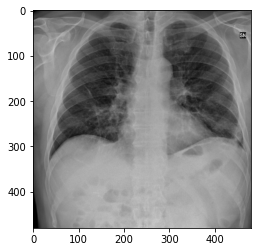

In [10]:
import matplotlib.pyplot as plt

plt.imshow(img[0])

For data marshalling reason, we will flatten the image and convert it to a list.

We can then send the data to be processed by the BlindAI server!

In [11]:
with blindai.Connection(api_key=api_key) as client:
  # Send data to the ResNet18 model
  response = client.predict("covidnet", img)

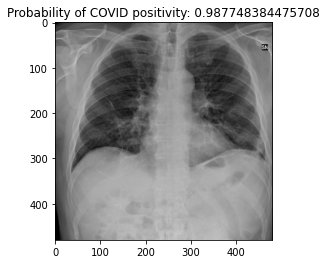

In [18]:
plt.imshow(img[0])
plt.title(f"Probability of COVID positivity: {response.output[0].as_flat()[1]}")

print(response.output)

Here we can compare the results against the original prediction.

In [19]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("COVID-Net-CXR-2.onnx")
ort_inputs = {ort_session.get_inputs()[0].name: img}

onnx_outputs = ort_session.run(None, ort_inputs)
print(f"Probability of COVID positivity from original model: {onnx_outputs[0][0][1]}")

Probability of COVID positivity from original model: 0.9877482652664185


Et voila! We have been able to apply a start of the art model of image recognition, without ever having to show the data in clear to the people operating the service!

If you have liked this example, do not hesitate to drop a star on our [GitHub](https://github.com/mithril-security/blindai) and chat with us on our [Discord](https://discord.gg/TxEHagpWd4)!